# Ice Melt Contribution Ternary Plot Analysis

In [37]:
import numpy as np
import pandas as pd
import ternary
from matplotlib import pyplot as plt
from pyslfp import FingerPrint, IceModel
from tqdm import tqdm
from Part_III_Project import sea_surface_height_change
from joblib import Parallel, delayed

In [38]:
fp = FingerPrint()
fp.set_state_from_ice_ng(version=IceModel.ICE7G, date=0.0)


sat_data_range = np.arange(1, 91, 1)  # in degrees

error_output = pd.DataFrame()

print(max(sat_data_range))

90


In [39]:
# for segment in sat_data_range:
#     for west_contribution in np.arange(0, 1, 0.01):
#         for east_contribution in tqdm(np.arange(0, 1 - west_contribution, 0.01)):
#             green_contribution = 1 - west_contribution - east_contribution
#             # print(f"Greenland: {green_contribution}, West Antarctica: {west_contribution}, East Antarctica: {east_contribution}")

#             direct_load = (
#                 green_contribution * fp.greenland_load()
#                 + west_contribution * fp.west_antarctic_load()
#                 + east_contribution * fp.east_antarctic_load()
#             )

#             (
#                 sea_level_change,
#                 displacement,
#                 gravitational_potential_change,
#                 angular_velocity_change,
#             ) = fp(direct_load=direct_load)

#             sea_surface_height_change_result = sea_surface_height_change(
#                 fp, sea_level_change, displacement, angular_velocity_change
#             )
#             mean_sea_level_change = fp.mean_sea_level_change(direct_load)
#             altimetry_projection = fp.altimetry_projection(
#                 latitude_min=-segment, latitude_max=segment, value=0
#             )
#             altimetry_projection_integral = fp.integrate(altimetry_projection)
#             altimetry_weighting_function = (
#                 altimetry_projection / altimetry_projection_integral
#             )

#             mean_sea_level_change_estimate = fp.integrate(
#                 altimetry_weighting_function * sea_surface_height_change_result
#             )

#             error = (
#                 100
#                 * np.abs(mean_sea_level_change_estimate - mean_sea_level_change)
#                 / np.abs(mean_sea_level_change)
#             )

#             error_output = pd.concat(
#                 [
#                     error_output,
#                     pd.DataFrame(
#                         {
#                             "segment": [segment],
#                             "greenland_contribution": [green_contribution],
#                             "west_antarctic_contribution": [west_contribution],
#                             "east_antarctic_contribution": [east_contribution],
#                             "error": [error],
#                         }
#                     ),
#                 ],
#                 ignore_index=True,
#             )

In [40]:
def compute_error_for_combination(segment, west_contribution, east_contribution, fp):
    green_contribution = 1 - west_contribution - east_contribution

    direct_load = (
        green_contribution * fp.greenland_load()
        + west_contribution * fp.west_antarctic_load()
        + east_contribution * fp.east_antarctic_load()
    )

    (
        sea_level_change,
        displacement,
        gravitational_potential_change,
        angular_velocity_change,
    ) = fp(direct_load=direct_load)

    sea_surface_height_change_result = sea_surface_height_change(
        fp, sea_level_change, displacement, angular_velocity_change
    )
    mean_sea_level_change = fp.mean_sea_level_change(direct_load)
    altimetry_projection = fp.altimetry_projection(
        latitude_min=-segment, latitude_max=segment, value=0
    )
    altimetry_projection_integral = fp.integrate(altimetry_projection)
    altimetry_weighting_function = altimetry_projection / altimetry_projection_integral

    mean_sea_level_change_estimate = fp.integrate(
        altimetry_weighting_function * sea_surface_height_change_result
    )

    error = (
        100
        * np.abs(mean_sea_level_change_estimate - mean_sea_level_change)
        / np.abs(mean_sea_level_change)
    )

    return {
        "segment": segment,
        "greenland_contribution": green_contribution,
        "west_antarctic_contribution": west_contribution,
        "east_antarctic_contribution": east_contribution,
        "error": error,
    }


# Generate all combinations
tasks = []
for segment in sat_data_range:
    for west_contribution in np.arange(0, 1, 0.01):
        for east_contribution in np.arange(0, 1 - west_contribution, 0.001):
            tasks.append((segment, west_contribution, east_contribution))

# Run in parallel
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(compute_error_for_combination)(seg, west, east, fp)
    for seg, west, east in tasks
)

error_output = pd.DataFrame(results)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  

KeyboardInterrupt: 

In [43]:
# error_output.to_csv("ternary_sea_surface_height_error_large.csv")
error_output = pd.read_csv("ternary_sea_surface_height_error.csv")

/tmp/ipykernel_44155/1464963812.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tax.heatmap(data_dict, style="triangular", cmap=plt.cm.get_cmap('viridis'),


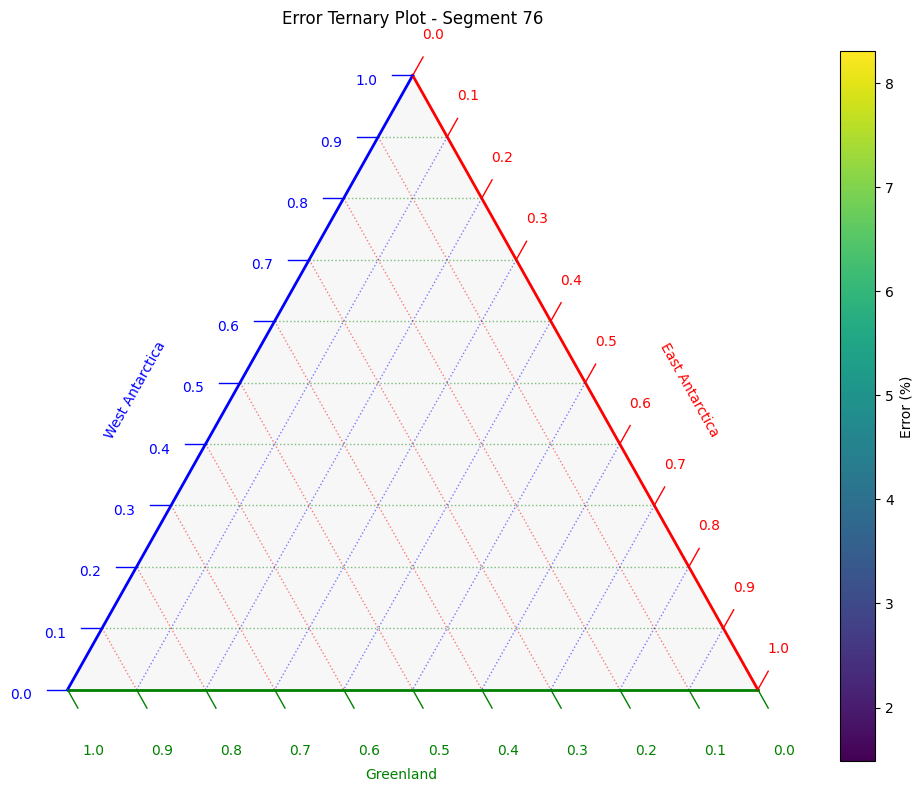

In [ ]:
# plot ternary of east vs west v green error for segment 76

# Filter data for segment 76
segment_data = error_output[error_output["segment"] == 76].copy()

# Prepare data for ternary plot
scale = 100

# Create a dictionary mapping (east, west, green) to error values
data_dict = {}
for _, row in segment_data.iterrows():
    # Convert to ternary coordinates (must sum to scale)
    east = int(round(row["east_antarctic_contribution"] * scale))
    west = int(round(row["west_antarctic_contribution"] * scale))
    green = int(round(row["greenland_contribution"] * scale))

    # Ternary library uses (bottom, left, right) convention
    # Map: green (bottom), west (left), east (right)
    data_dict[(green, west, east)] = row["error"]

# Dictionary of axes colors for bottom (b), left (l), right (r).
axes_colors = {"b": "g", "l": "b", "r": "r"}

fig, ax = plt.subplots(figsize=(10, 8))
ax.axis("off")
figure, tax = ternary.figure(ax=ax, scale=scale)

# Plot heatmap with triangular style for better filling
tax.heatmap(
    data_dict,
    style="triangular",
    cmap=plt.cm.get_cmap("viridis"),
    cbarlabel="Error (%)",
    colorbar=True,
)

tax.boundary(linewidth=2.0, axes_colors=axes_colors)

tax.left_axis_label("West Antarctica", offset=0.16, color=axes_colors["l"])
tax.right_axis_label("East Antarctica", offset=0.16, color=axes_colors["r"])
tax.bottom_axis_label("Greenland", offset=0.06, color=axes_colors["b"])

tax.gridlines(
    multiple=10,
    linewidth=1,
    horizontal_kwargs={"color": axes_colors["b"]},
    left_kwargs={"color": axes_colors["l"]},
    right_kwargs={"color": axes_colors["r"]},
    alpha=0.5,
)

# Set and format axes ticks.
ticks = [i / float(scale) for i in range(0, scale + 1, 10)]
tax.ticks(
    ticks=ticks,
    axis="rlb",
    linewidth=1,
    clockwise=True,
    axes_colors=axes_colors,
    offset=0.03,
    tick_formats="%.1f",
)

tax.clear_matplotlib_ticks()
tax._redraw_labels()
plt.title(f"Error Ternary Plot - Segment 76", pad=20)
plt.tight_layout()
tax.show()